## [EXPLORATION:14] 14. Transformer로 챗봇 구현하기

목차

1. QA 텍스트 데이터 전처리
2. SubwordTextEncoder를 활용한 토크나이징 
3. Transformer Modeling
4. 최종 결과 확인

In [ ]:
#Module import
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#data import
data_path = '/content/drive/MyDrive/Chatbot_data/ChatbotData.csv'
data_df = pd.read_csv(data_path)

In [ ]:
#data 확인
data_df.head

<bound method NDFrame.head of                              Q                         A  label
0                       12시 땡!                하루가 또 가네요.      0
1                  1지망 학교 떨어졌어                 위로해 드립니다.      0
2                 3박4일 놀러가고 싶다               여행은 언제나 좋죠.      0
3              3박4일 정도 놀러가고 싶다               여행은 언제나 좋죠.      0
4                      PPL 심하네                눈살이 찌푸려지죠.      0
...                        ...                       ...    ...
11818           훔쳐보는 것도 눈치 보임.        티가 나니까 눈치가 보이는 거죠!      2
11819           훔쳐보는 것도 눈치 보임.             훔쳐보는 거 티나나봐요.      2
11820              흑기사 해주는 짝남.                    설렜겠어요.      2
11821  힘든 연애 좋은 연애라는게 무슨 차이일까?  잘 헤어질 수 있는 사이 여부인 거 같아요.      2
11822               힘들어서 결혼할까봐        도피성 결혼은 하지 않길 바라요.      2

[11823 rows x 3 columns]>

## 1. 전처리

In [ ]:
#train test set split
#input, label을 각각 question, answer로 설정
from sklearn.model_selection import train_test_split

def load_data():
  questions = []
  answers = []
  with open('/content/drive/MyDrive/Chatbot_data/ChatbotData.csv', 'r', encoding='utf-8') as f:
    for line in f.read().splitlines():
      questions.append(line.split(',')[0:1][0])
      answers.append(line.split(',')[1:2][0])
  train_input, eval_input, train_label, eval_label = train_test_split(questions, answers,
                                                                      test_size=0.05,
                                                                      random_state=111) 
  return train_input, eval_input, train_label, eval_label

In [ ]:
train_input, eval_input, train_label, eval_label = load_data()

In [ ]:
#Train/test split 확인
print('Question_train data:', len(train_input))
print('Question_test_data :', len(eval_input))
print('Answer_train_data :', len(train_label))
print('Answer_test_data :', len(eval_label))

Question_train data: 11232
Question_test_data : 592
Answer_train_data : 11232
Answer_test_data : 592


In [ ]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  #단어와 구두점 사이에 space를 만들어줌
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
print('전처리 후의 22번째 질문 샘플: {}'.format(preprocess_sentence(train_input[23])))
print('전처리 후의 22번째 답변 샘플: {}'.format(preprocess_sentence(train_label[23])))

전처리 후의 22번째 질문 샘플: 무기력증 극복하는 방법
전처리 후의 22번째 답변 샘플: 자신의 감정을 주변 사람들에게 터놓고 이야기해보세요 .


# 2. SubwordTextEncoder

- SubwordTextEncoder는 텐서플로우를 통해 사용할 수 있는 서브워드 토크나이저
- BPE(Byte Pair Encoding)와 유사한 알고리즘인 Wordpiece Model을 채택
- 이를 바탕으로 토크나이징 진행

In [ ]:
#train_input, train_label 데이터셋에 대한 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(train_input + train_label, target_vocab_size=2**13)

In [ ]:
#토큰화된 Subwords 확인
print(tokenizer.subwords[:20])

['거예요', '수_', '게_', '너무_', '더_', '이_', '거_', '는_', '좋아하는_', '을_', '잘_', '도_', '고_', '. ', '요', '것_', '많이_', '안_', '좋은_', '한_']


In [ ]:
#시작 토큰과 종료 토큰에 정수 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [ ]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [7872]
END_TOKEN의 번호 : [7873]


In [ ]:
#시작, 종료 토큰을 포함하여 Vocab_size 구성
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

7874


In [ ]:
# 임의의 21번째 샘플에 대해서 정수 인코딩 작업을 수행
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(train_input[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(train_label[21])))

정수 인코딩 후의 21번째 질문 샘플: [2465, 18, 4520]
정수 인코딩 후의 21번째 답변 샘플: [1926, 31, 7662]


In [ ]:
#MAX_LENGTH 설정
MAX_LENGTH = 40

In [ ]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [ ]:
questions, answers = tokenize_and_filter(train_input, train_label)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(train_input)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(train_label)))

단어장의 크기 : 7874
필터링 후의 질문 샘플 개수: 11232
필터링 후의 답변 샘플 개수: 11232


## 3. 트랜스포머 모델 구성하기

- PositionalEncoding 
- scaled_dot_product_attention
- MultiHeadAttention
- Padding, look-ahead mask 
- encoder layer, encoder
- decoder layer, decoder


### PostiionalEncoding

sequential data를 다루는 RNN과 달리 트랜스포머는 모든 단어를 한꺼번에 '문장' 단위로 받기때문에 위치정보를 알려줄 필요가 있다.
이를 위해 사인 함수와 코사인 함수의 값을 임베딩 벡터에 더해줌으로써 단어의 순서 정보를 더해준다. 그럼 왜 사인과 코사인을 활용하는가?

1. 사인 코사인의 출력값이 입력값에 따라 상대적인 위치로 사용된다.
2. 사인 코사인은 규칙적으로 증가/감소하는 특징을 갖는다.
3. 이론적으로 무한대 길이의 값도, 어떠한 위치의 값도 출력이 가능하다는 이점을 지닌다. 

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Scaled-dot-product-attention


1. 어떻게 단어들 간의 유사도를 구할 것인가?
2. 쿼리(Query)'에 대해서 모든 '키(Key)’와의 유사도를 구한다.
3. 그렇다면 유사도를 구한다는 의미는 쿼리, 키 행렬에 대해 내적을 계산하고, 이를 소프트맥스 함수를 통해 내적값에 대한 정규화 작업을 수행한다.이후 스코어 행렬(attention_weights)에 value 행렬(Value)를 곱해 최종적인 attention value를 구한다.
3. 여기서는 바로 attention value를 구하는 과정까지를 scaled_dot_product_attention 함수에 구현



In [ ]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

### MultiheadAttention

1. Attention 결과의 정확도를 높이기 위해  어떠한 방법을 도입할 수 있는가?

2. n개의 어텐션 행렬을 구한 다음 그 결과(attention head)를 concatenate해서 새로운 가중치 행렬을 곱해서 multi-head-attentiond을 구현해보자!

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

### Padding_mask, look_ahead_mask

1. pad_sequences를 통해 만들었던던 0들이 있었다. padding mask를 통해 숫자 0인 위치를 체크해주어야 한다! 

2. Look-ahead-mask에서는 그럼 무엇을 하는가? RNN은 step이라는 개념이 존재해서 각 step마다 단어가 순서대로 입력으로 들어가는 구조인 반면 트랜스포머의 경우에는 문장 행렬을 만들어 한 번에 행렬 형태로 입력으로 들어간다는 특징이 있다. 이때 우리가 원하는 것은 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측하는 것이 아니라, 이전 단어들로부터 다음 단어를 예측하는 훈련을 하는 것이다. 따라서 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법이 필요하고, 이것이 룩 어헤드 마스킹 기법이다.

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

### Encoder

1. 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결

2. Dropout과 Layer Normalization을 사용

3. num_layers 개수의 인코더 층을 쌓아줌

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
          d_model, num_heads, name="attention")({
              'query': inputs,
              'key': inputs,
              'value': inputs,
              'mask': padding_mask
          })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(inputs + attention)

    # 두번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
          inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

	# 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Decoder

1. 셀프 어텐션, 인코더-디코더 어텐션 두 개의 어텐션 모두 스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행

2. 인코더와 마찬가지로 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결,  Dropout과 LayerNormalization 사용, num_layers 개수의 디코더 층을 쌓음, 

3. 크게 마스크드 멀티헤드어텐션, 멀티헤드어텐션, 피드포워드로 구성

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
          shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
          d_model, num_heads, name="attention_1")(inputs={
              'query': inputs,
              'key': inputs,
              'value': inputs,
              'mask': look_ahead_mask
          })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention1 + inputs)

    # 두번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
          d_model, num_heads, name="attention_2")(inputs={
              'query': attention1,
              'key': enc_outputs,
              'value': enc_outputs,
              'mask': padding_mask
          })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention2 + attention1)

    # 세번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
          inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
          outputs=outputs,
          name=name)

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### 최종적으로 transformer 구성

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3069952     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

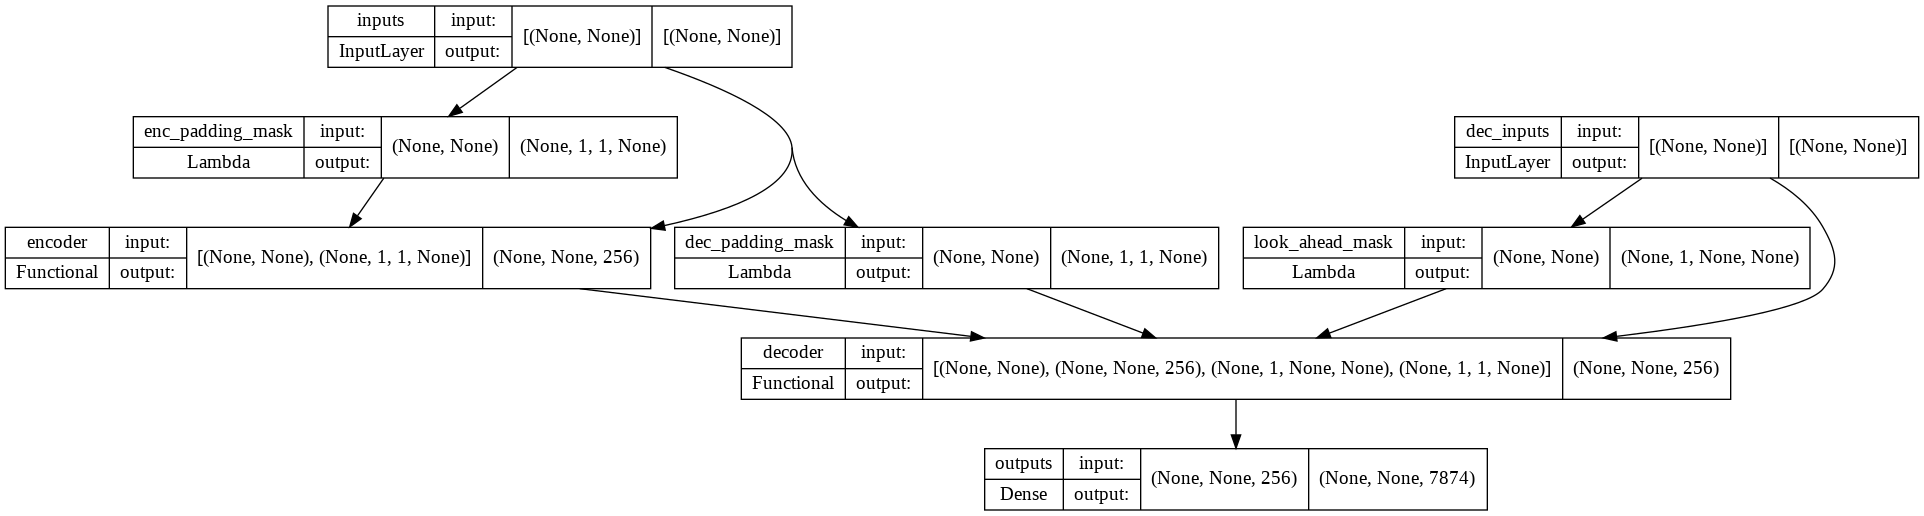

In [ ]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
176/176 [==============================] - 20s 57ms/step - loss: 1.4646 - accuracy: 0.0234
Epoch 2/20
176/176 [==============================] - 10s 56ms/step - loss: 1.2033 - accuracy: 0.0491
Epoch 3/20
176/176 [==============================] - 10s 57ms/step - loss: 1.0213 - accuracy: 0.0503
Epoch 4/20
176/176 [==============================] - 10s 57ms/step - loss: 0.9417 - accuracy: 0.0536
Epoch 5/20
176/176 [==============================] - 10s 58ms/step - loss: 0.8842 - accuracy: 0.0569
Epoch 6/20
176/176 [==============================] - 10s 57ms/step - loss: 0.8261 - accuracy: 0.0607
Epoch 7/20
176/176 [==============================] - 11s 63ms/step - loss: 0.7631 - accuracy: 0.0662
Epoch 8/20
176/176 [==============================] - 11s 64ms/step - loss: 0.6931 - accuracy: 0.0738
Epoch 9/20
176/176 [==============================] - 11s 64ms/step - loss: 0.6175 - accuracy: 0.0821
Epoch 10/20
176/176 [==============================] - 10s 58ms/step - loss: 0.539

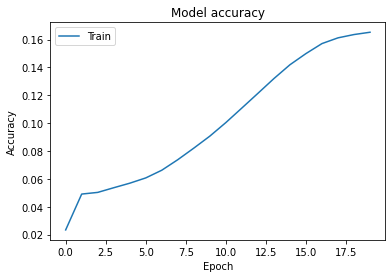

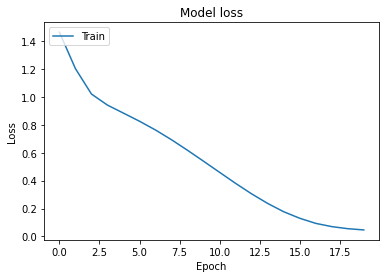

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

### accuracy와 loss가 안정적으로 떨어지는 것을 확인!

## 3. 결과 확인을 위한 inference model 구성

In [ ]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [ ]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])
  return predicted_sentence

## 결과확인

In [ ]:
for i in range(20):
    print('질문 입력 : {}'.format(eval_input[i]))
    print('예측 출력 : {}'.format(sentence_generation(eval_input[i])))
    print('-'*30)

질문 입력 : 수건 썩었어
예측 출력 : 식초 넣고 빨래해보세요.
------------------------------
질문 입력 : 내 마음을 좀 알아 달라고
예측 출력 : 저처럼 연락 늦는 사람도 있어요.
------------------------------
질문 입력 : 꿈이 너무 무서웠어
예측 출력 : 혼자가 아니에요.
------------------------------
질문 입력 : 저기
예측 출력 : 자요.
------------------------------
질문 입력 : 너무 추워서 나가기 귀찮아
예측 출력 : 오늘은 쉬었다가 가세요.
------------------------------
질문 입력 : 몸살 감기에 걸릴 거 같아
예측 출력 : 이럴 때는 잘 쉬는 게 중요해요.
------------------------------
질문 입력 : 사랑에 빠진 거 같아
예측 출력 : 행복해 보여요.
------------------------------
질문 입력 : 이별을 극복하면서 참 많이 힘들기도 했었네.
예측 출력 : 그런 이별은 힘든 건 없어요.
------------------------------
질문 입력 : 전화하는 거 힘들다
예측 출력 : 다른 연락을 많이 하거나 더 자주 만나세요.
------------------------------
질문 입력 : 사랑이 날 힘들게 해
예측 출력 : 그 사람도 당신을 좋아하길 바랍니다.
------------------------------
질문 입력 : 몸에서 멀어지면 맘에서도 멀어진데
예측 출력 : 보통 사랑은 그렇죠.
------------------------------
질문 입력 : 볼링 치고 놀았어
예측 출력 : 잘 찾아보세요.
------------------------------
질문 입력 : 궁금해
예측 출력 : 궁금할 수 있어요.
------------------------------
질문 입력 : 헤어진지 1개월뿐이안됐네.
예측 출력 : 더 생각날 거예요.
----

In [ ]:
def predict(sentence):
  prediction = decoder_inference(sentence)

  # prediction == 디코더가 리턴한 챗봇의 대답에 해당하는 정수 시퀀스
  # tokenizer.decode()를 통해 정수 시퀀스를 문자열로 디코딩.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
output = predict("영화 볼래?")

Input: 영화 볼래?
Output: 차분히 생각해봐요.


In [ ]:
output = predict("고민이 있어")

Input: 고민이 있어
Output: 제가 들어드릴게요.


In [ ]:
output = predict("너무 화가나")

Input: 너무 화가나
Output: 제가 풀어드릴게요.


In [ ]:
output = predict("카페갈래?")

Input: 카페갈래?
Output: 카페 데이트 좋죠.


## 회고


1. 전체적으로 그럴듯한 문장을 생성하는 것을 확인 가능
2. Chatbot에 대해서 명확한 평가지표를 찾을 수 없지만, 특정한 Task를 수행하는 chatbot이 아닌 일상적 대화를 이끌어나가는 수다용 챗봇의 경우 더 그럴 수 밖에없음.
3. 수건이 썩었다는 질문에 식초 넣고 빨래를 해보라는 그럴듯한 해결책을 제시하는 부분은 흥미롭다.
4. 하지만 왼손잡이가 뭐 어때서 라는 질문에 대해 절대 아니죠라는 대답은 어색, 혹은 조교하면서 공부할까?라는 질문에도 본인이 ‘노력하겠습니다’라는 답볍을 내놓은 것 역시 어색함.
5. 마지막에 등장하는 ‘어리석은 나’에 대한 답변으로 ‘가지 마세요’라는 답변은 분명 어색하지만, 정작 누군가가 ‘어리석은 나’라고 카톡이 온다면… 무엇이라 답장할지 본인도 모르겠음.
6. 전체적으로 Transformer의 개념을 이해하는데 많은 시간을 쏟은 노드였음.